In [20]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import neighbors, datasets
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [21]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [22]:
class Preencher_vazios(BaseEstimator, TransformerMixin):

    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # values = {'Age': train['Age'].median(),'Cabin':'C1000','Embarked':'X'}
        X.fillna(value=self.values, inplace = True)        
        return X

In [23]:
class Transformar_categoricos(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.apply(lambda x: pd.factorize(x)[0])        
        return X

In [24]:
def zero_um(matriz):
    matriz[np.where(matriz<=0.50)] = 0
    matriz[np.where(matriz>0.50)] = 1
    return matriz

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    #plt.xlim([0, 1])

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [28]:
train = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [29]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [30]:
test_set.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008211
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,0.008211,-0.577147,0.337932,0.171539,0.230046,1.000000


In [31]:
train = train.set_index('PassengerId')
test_set = test_set.set_index('PassengerId')

lista_index_train = train.index.tolist()
lista_index_test_set = test_set.index.tolist()

todos = pd.concat([train,test_set],axis=0)

test_set = todos.loc[lista_index_test_set].reset_index()
todos = todos.reset_index()

train_label = train['Survived']
train_set = todos.loc[lista_index_train].drop('Survived', axis=1)

In [32]:
#for index, row in todos.iterrows():
#    print (type(todos.iloc[index]['Name']))

In [33]:
l = list()
todos['Name_3'] = ""
for index, row in todos.iterrows():   
    try:
        a = float(todos.iloc[index]['Age'])
                  
        if np.isnan(a):
            tipo = 'nan'   
        elif not np.isnan(a):
            tipo = 'ok'
    except:
        tipo = 'nan'
        
    jl = todos.iloc[index]['Name']
    c = re.match('(.*?)[\s]*[\,][\s]*', jl)
    a = re.match('(.*?)[\s]*[\,][\s]*Mr[\.\s].*', jl)
    b = re.match('(.*?)[\s]*[\,][\s]*Dr[\.\s].*', jl)

    d = re.match('(.*?)[\s]*[\,][\s]*Master[\.\s].*', jl)    

    e = re.match('(.*?)[\s]*[\,][\s]*Miss[\.\s].*', jl)
    f = re.match('(.*?)[\s]*[\,][\s]*Mrs[\.\s].*', jl)
    g = re.match('(.*?)[\s]*[\,][\s]*Ms[\.\s].*', jl)

    h = re.match('(.*?)[\s]*[\,][\s]Rev[\.\s].*', jl)

    i = re.match('(.*?)[\s]*[\,][\s]*Col[\.\s].*', jl)
    j = re.match('(.*?)[\s]*[\,][\s]*Major[\.\s].*', jl)

    if   a: 
        l.append(0)
    elif b:
        l.append(0)
    elif d:
        l.append(2)
    elif e:       
        l.append(3)
    elif f:       
        l.append(4)
    elif g:       
        l.append(5)
    elif h:       
        l.append(6)
    elif i:       
        l.append(6)
    elif j:       
        l.append(6)
    else:
        l.append(7) 
    
    if c:
        todos.at[index, 'Name_3'] = c.group(1)
    
    
    if (a or b  or e or g or h or i or f) and (tipo == 'nan'):
        todos.at[index, 'Age'] = 28.
        
    elif (d) and (tipo == 'nan'):       
        todos.at[index, 'Age'] = 4.
        
    elif (tipo == 'nan'):
        todos.at[index, 'Age'] = 28.
        
todos['Name_2'] = l
#todos['Surname'] = sur

In [34]:
todos[todos['Name'].str.contains('Ms.')]

,PassengerId,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Name_3,Name_2
443,444,28.0,NaN,S,13.00,"Reynaldo, Ms. Encarnacion",0,2,female,0,1.0,230434,Reynaldo,5
979,980,28.0,NaN,Q,7.75,"O'Donoghue, Ms. Bridget",0,3,female,0,NaN,364856,O'Donoghue,5


In [35]:
todos['Cabin_2']= todos['Cabin'].str.extract('(.).*', expand=False)

In [36]:
#todos['Cabin_2'].unique()

In [37]:
#todos[0:891].groupby(['Name_3','Survived'])['PassengerId'].count()[640:700]

In [38]:
count = 0
nosurv = 0
surv = 0
s_ns = list()
s_ns_novo = list()
c_dict ={}
c_dict_baixo ={}
c_dict_alto ={}
todos['Name_4'] = ""
for index, row in todos[0:891].iterrows():  
    if todos.iloc[index]['Name_3'] not in c_dict.keys():
        c_dict[todos.iloc[index]['Name_3']] = [0,0]
    
    s_ns = c_dict[todos.iloc[index]['Name_3']]
    
    if todos[0:891].iloc[index]['Survived'] == 0:            
        s_ns_novo = [s_ns[0] + 1, s_ns[1]]
    elif todos[0:891].iloc[index]['Survived'] == 1: 
        s_ns_novo = [s_ns[0], s_ns[1] + 1]
        
    c_dict[todos[0:891].iloc[index]['Name_3']] = s_ns_novo
                
for count in c_dict.keys():
    if sum(c_dict[count]) > 1: # 2 for not overfitting
        c_dict_baixo[count] = c_dict[count][1]/sum(c_dict[count])
    
    if sum(c_dict[count]) > 1:
        c_dict_alto[count] = c_dict[count][1]/sum(c_dict[count])

    
for index, row in todos.iterrows():     
    if todos.iloc[index]['Name_3'] in c_dict_baixo and (index < 891):
        todos.at[index, 'Name_4'] = c_dict_baixo[todos.iloc[index]['Name_3']]
        
    elif todos.iloc[index]['Name_3'] in c_dict_alto and (index >= 891):   
        todos.at[index, 'Name_4'] = c_dict_alto[todos.iloc[index]['Name_3']]    
        
    else:
            todos.at[index, 'Name_4'] = 0.38


In [39]:
#todos[0:891].groupby(['Cabin_2','Survived'])['Survived'].count()
len(todos[0:891][todos[0:891]['Survived']==1])/len(todos[0:891])

0.3838383838383838

In [40]:
len(todos[0:891][todos[0:891]['Name_4'] != 0.38])/len(todos[0:891]), len(todos[891:][todos[891:]['Name_4'] != 0.38])/len(todos[891:])

(0.4006734006734007, 0.19138755980861244)

In [41]:

todos = todos.drop(['Name_2', 'Name', 'Cabin', 'Ticket'], axis = 1)

In [42]:
#todos[880:900]

In [43]:
num_attribs = ['Fare', 'Age','Name_4','Parch','SibSp']
cat_attribs = ['Pclass','Sex','Embarked']
values_num = {'Fare': train_set['Fare'].median()}
values_cat = {'Cabin':'X','Cabin_2':'X', 'Embarked' : 'X'}

num_attribs = ['Fare', 'Age']
cat_attribs = ['Pclass','Sex','Parch','Embarked']
#
values_num = {'Age': train_set['Age'].median(), 'Fare': train_set['Fare'].median()}
values_cat = {'Cabin':'C1000', 'Embarked' : 'X'}

In [44]:
num_pipeline = Pipeline([
        ('Preencher_vazios', Preencher_vazios(values_num)),
        ('pd-np', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('Preencher_vazios', Preencher_vazios(values_cat)),
        ('Transformar_categoricos',Transformar_categoricos()),
        ('pd-np', DataFrameSelector(cat_attribs)),
        ('OneHotEncoder',OneHotEncoder()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [1]:
cat_tr = full_pipeline.fit_transform(todos)

train2 = cat_tr[0:891]
train3 = cat_tr[891:]

NameError: name 'full_pipeline' is not defined

In [46]:
#train2.toarray()[:,3]

In [47]:
####LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(train2, train_label[0:891])

s = lin_reg.predict(train2)
s = zero_um(s)
print (accuracy_score(s, train_label[0:891]))

t = lin_reg.predict(train3)
t = zero_um(t)

result_lin = pd.concat([pd.DataFrame(data=t,columns =['Survived']),
   test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
   .astype('int64')

res2 = np.array(result_lin)

result_lin.to_csv('lin.csv')

0.8698092031425365


s = lin_reg.predict(cat_tr[0:870])
s = zero_um(s)
print (accuracy_score(s, train_label[0:870]))


In [48]:
val = int(891 * 0.8)
print (val)
accu = dict()
ll = list()
for i in range(10):
    sh = np.random.permutation(891)
    sh1 = list(sh[0:val])
    sh2 = list(sh[val:891])
    lin_reg2 = LinearRegression()
    train22 = cat_tr[sh1]
    train_label22 = train_label.iloc[sh1] 
    lin_reg2.fit(train22, train_label22)
    s = lin_reg2.predict(train22)
    s = zero_um(s)
    accu2 = (accuracy_score(s, train_label22))
    train33 = cat_tr[sh2]
    s = lin_reg2.predict(train33)
    s = zero_um(s)
    ll.append((accuracy_score(s, train_label.iloc[sh2])))
    dd= ('%.2f%s%.2f' % ((accuracy_score(s
                                         , train_label.iloc[sh2]))," ", accu2) )
    accu[i] = (dd)
    #print (accu2)
#for i in accu.keys():
  #  print ('%s%s%s' % (i," ",accu[i]))
print (min(ll))
print (max(ll))



712
0.8379888268156425
0.9162011173184358


In [49]:
## RandomForestRegressor
#forest_reg = RandomForestRegressor()
forest_reg =RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

forest_reg.fit(train2, train_label)
s = forest_reg.predict(train2)
s = zero_um(s)
print (accuracy_score(s, train_label))

t = forest_reg.predict(train3)
t = zero_um(t)

result_random_forest = pd.concat([pd.DataFrame(data=t,columns =['Survived']),
    test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
    .astype('int64')

result_random_forest.to_csv('random_forest.csv')
#res2 = np.hstack([res2, np.array(result_random_forest)])

0.9831649831649831


In [50]:
#SGD######################################################################
sgd_clf = SGDClassifier(max_iter=1000)
sgd_clf.fit(train2, train_label)

s = sgd_clf.predict(train2)
print (accuracy_score(s, train_label))

t = sgd_clf.predict(train3)
t = zero_um(t)

result_SGD = pd.concat([pd.DataFrame(data=t,columns =['Survived']),
    test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
    .astype('int64')

res2 = np.hstack([res2, np.array(result_SGD)])

result_SGD.to_csv('SGD.csv')

0.8653198653198653


In [51]:
scores = cross_val_score(sgd_clf, train2, train_label,
     scoring="accuracy", cv=10)

display_scores(scores)

Scores: [0.88888889 0.9        0.84269663 0.87640449 0.8988764  0.84269663
 0.86516854 0.78651685 0.88764045 0.84090909]
Mean: 0.862979797979798
Standard deviation: 0.033585734016861345


In [52]:
y_train_pred = cross_val_predict(sgd_clf, train2, train_label, cv=10)
conf_mx = confusion_matrix(train_label, y_train_pred)
conf_mx

array([[505,  44],
       [ 80, 262]], dtype=int64)

In [53]:
knn=neighbors.KNeighborsClassifier()
knn.fit(train2, train_label)

s = knn.predict(train2)
print (accuracy_score(s, train_label))

t = knn.predict(train3)
result_knn = pd.concat([pd.DataFrame(data=t,columns =['Survived']),
    test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
    .astype('int64')
#res2 = np.hstack([res2, np.array(result_knn)])
result_knn.to_csv('knn.csv')

0.9023569023569024


In [54]:
scores = cross_val_score(knn, train2, train_label,
     scoring="accuracy", cv=10)

display_scores(scores)

Scores: [0.86666667 0.9        0.78651685 0.85393258 0.91011236 0.88764045
 0.8988764  0.85393258 0.8988764  0.875     ]
Mean: 0.8731554307116104
Standard deviation: 0.0345111335271843


In [55]:
y_train_pred = cross_val_predict(knn, train2, train_label, cv=10)
conf_mx = confusion_matrix(train_label, y_train_pred)
conf_mx

array([[503,  46],
       [ 67, 275]], dtype=int64)

In [56]:
svwm=svm.SVC(C= 35938.0, gamma= 0.000562)
#svwm=svm.SVC()
svwm.fit(train2, train_label)

s = svwm.predict(train2)
print (accuracy_score(s, train_label))

t = svwm.predict(train3)

result_svn = pd.concat([pd.DataFrame(data=t,columns =['Survived']),
    test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
    .astype('int64')
res2 = np.hstack([res2, np.array(result_svn)])

result_svn.to_csv('svn.csv')

0.8765432098765432


In [57]:
scores = cross_val_score(svwm, train2, train_label,
     scoring="accuracy", cv=10)

display_scores(scores)

Scores: [0.88888889 0.9        0.83146067 0.8988764  0.8988764  0.85393258
 0.86516854 0.83146067 0.8988764  0.85227273]
Mean: 0.8719813301554874
Standard deviation: 0.026991468972324288


In [58]:
y_train_pred = cross_val_predict(svwm, train2, train_label, cv=10)
conf_mx = confusion_matrix(train_label, y_train_pred)
conf_mx

array([[512,  37],
       [ 77, 265]], dtype=int64)

In [59]:
#plt.matshow(conf_mx, cmap=plt.cm.gray)
#plt.show()

In [60]:
precision_score(train_label, y_train_pred), recall_score(train_label, y_train_pred), f1_score(train_label, y_train_pred)

(0.8774834437086093, 0.7748538011695907, 0.8229813664596273)

In [61]:
y_train_pred = cross_val_predict(svwm, train2, train_label, cv=5,method="decision_function")

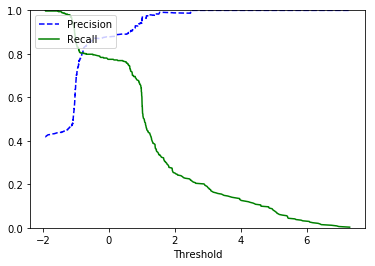

In [62]:
precisions, recalls, thresholds = precision_recall_curve(train_label, y_train_pred)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

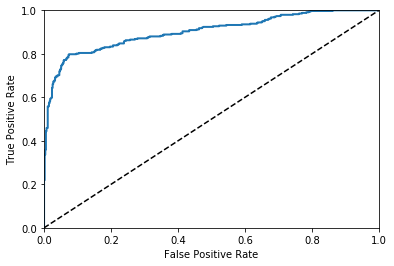

0.9019109705045858

In [63]:
fpr, tpr, thresholds = roc_curve(train_label, y_train_pred)
plot_roc_curve(fpr, tpr)
plt.show()
roc_auc_score(train_label, y_train_pred)

C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(train2, train_label)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [64]:
np.logspace(-9, 3, 2)

array([1.e-09, 1.e+03])

##GRID SEARCH

param_grid = [
    {'n_estimators': [300, 500, 700], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(train2, train_label)

print (grid_search.best_params_)
print (grid_search.best_estimator_)


In [65]:
#np.logspace(-2, 10, 5)

In [66]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1).fit(train2, train_label)

s = gbm.predict(train2)

print (accuracy_score(s, train_label))

t = gbm.predict(train3)

result_xgb = pd.concat([pd.DataFrame(data=t,columns =['Survived']),
    test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
    .astype('int64')
    
    
#res2 = np.hstack([res2, np.array(result_xgb)])

result_xgb.to_csv('xgb.csv')

0.9304152637485971


C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [67]:
scores = cross_val_score(gbm, train2, train_label,
     scoring="accuracy", cv=10)

display_scores(scores)

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

Scores: [0.9        0.88888889 0.82022472 0.8988764  0.93258427 0.88764045
 0.91011236 0.83146067 0.8988764  0.88636364]
Mean: 0.8855027806151401
Standard deviation: 0.0325403226825441


C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
y_train_pred = cross_val_predict(gbm, train2, train_label, cv=10)
conf_mx = confusion_matrix(train_label, y_train_pred)
conf_mx

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

array([[511,  38],
       [ 64, 278]], dtype=int64)

In [69]:
soma = np.sum(res2, axis=1)
resultado_final_1 = (soma > 1)*1
#print (resultado_final_1)
result_final = pd.concat([pd.DataFrame(data=resultado_final_1,columns =['Survived']),
    test_set['PassengerId'].to_frame()],axis=1).set_index('PassengerId')\
    .astype('int64')

result_final.to_csv('result_final.csv')